In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Find all measurement class table columns
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
measurement_columns = Base.classes.measurement.__table__.columns.keys()
measurement_columns = pd.DataFrame(measurement_columns, columns=['column_name'])
measurement_columns

,column_name
0,id
1,station
2,date
3,prcp
4,tobs


In [12]:
# Find all station class table columns
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [13]:
station_columns = Base.classes.station.__table__.columns.keys()
station_columns = pd.DataFrame(station_columns, columns=['column_name'])
station_columns

,column_name
0,id
1,station
2,name
3,latitude
4,longitude
5,elevation


# Exploratory Climate Analysis

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

<AxesSubplot:xlabel='date'>

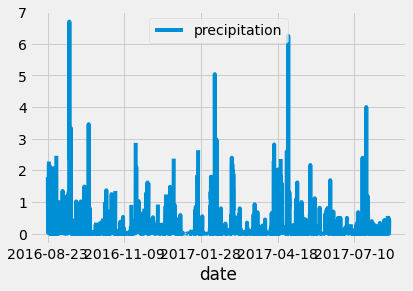

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the last data point in the database. 
last_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
prev_year = last_date - dt.timedelta(days=365)
# prev_year

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= prev_year).all()
print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
# print(df.head(30))

# Sort the dataframe by date
df = df.sort_index()
# print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()


<AxesSubplot:xlabel='date'>

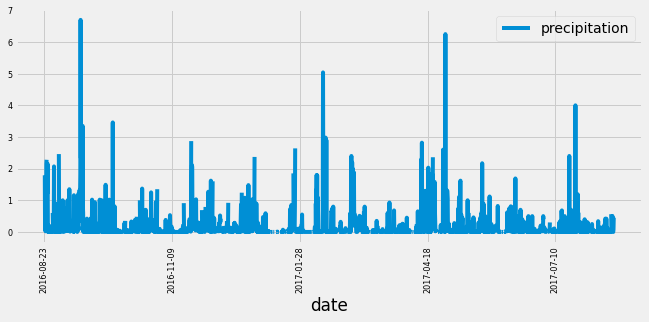

In [15]:
df.plot(figsize=(10,4), fontsize=(8), rot=90)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

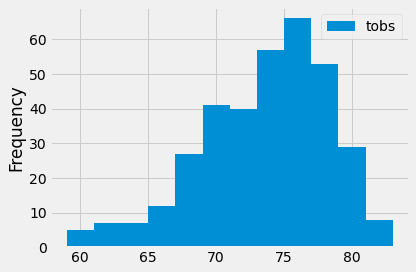

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
# print(results)
# df = pd.DataFrame(results, columns=['tobs'])
ly_temp_df = pd.DataFrame(results, columns=['tobs'])
# print(ly_temp_df)
ly_temp_df.plot.hist(bins=12)
plt.tight_layout()

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    
# Calculate the date range
    date_range = end_date - start_date
    
    # Perform a query to retrieve the dates and temp data
    results = []
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                            func.avg(Measurement.tobs)).\
                            filter(Measurement.date >= month_range).all()
    
    return results


In [25]:
calc_temps(dt.date(2016, 8, 23), (dt.date(2017, 8, 23)))

[(53.0, 87.0, 73.09795396419437)]

In [23]:
# retrieve monthly stats using month start and end date for range
start_date = dt.date(2016, 8, 23)
end_date = dt.date(2017, 8, 23)
    
# Calculate the date range
month_range = end_date - start_date
    
# Perform a query to retrieve the dates and temp data
results = []
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                        func.avg(Measurement.tobs)).\
                        filter(Measurement.date >= month_range).all()
print(results)

[(53.0, 87.0, 73.09795396419437)]


# Challenge